In [1]:
import numpy as np
import sys, os
import argparse
import gc
import torch
import time
import h5py
import copy
import torchvision.models as models
import torch.nn as nn

#import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from utils import prf_utils, torch_utils, texture_utils, default_paths, nsd_utils
from model_fitting import initialize_fitting

In [2]:
features_file = '/user_data/mmhender/features/CLIP/S1_RN50_block1_features_each_prf_grid5.h5py'
t = time.time()
with h5py.File(features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,0:2])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

Took 332.24646 seconds to load file


In [14]:
import scipy.stats
badvals = values[:,np.sum(np.isnan(scipy.stats.zscore(values[:,:,0])), axis=0)>0,0]

In [18]:
zero_var = np.var(values[:,:,0], axis=0)==0
np.sum(zero_var)

1

In [40]:
features_in_prf = values[:,:,0]
trninds = np.arange(10000)<10
n_features = values.shape[1]
zgroup_labels = np.ones(shape=(1,n_features))


In [49]:
from utils import numpy_utils
features_in_prf_z = np.zeros_like(features_in_prf)
features_in_prf_z[trninds,:] = numpy_utils.zscore_in_groups(features_in_prf[trninds,:], zgroup_labels)
features_in_prf_z[~trninds,:] = numpy_utils.zscore_in_groups(features_in_prf[~trninds,:], zgroup_labels)
# if any feature channels had no variance, fix them now
zero_var = (np.var(features_in_prf[trninds,:], axis=0)==0) | \
            (np.var(features_in_prf[~trninds,:], axis=0)==0)
# features_in_prf_z[:,zero_var] = features_in_prf[0,zero_var]


In [50]:
features_in_prf_z[0,zero_var]

array([-0.92410981])

In [30]:
zero_var

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [12]:
values.shape

(10000, 256, 2)

In [62]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)
model, preprocess = clip.load("RN50", device=device)


In [63]:
# Load and prepare the image set to work with (all images for the current subject, 10,000 ims)
subject=1
stim_root = default_paths.stim_root
image_data = nsd_utils.get_image_data(subject)  
image_data = nsd_utils.image_uncolorize_fn(image_data)

n_images = image_data.shape[0]



Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [74]:
image_tensors.shape

torch.Size([5, 3, 240, 240])

In [64]:
n_layers = len(model.visual.layer1) + len(model.visual.layer2) + len(model.visual.layer3) + len(model.visual.layer4)
n_layers

16

In [110]:
# first making this subfunction that is needed to get the activation on a forward pass
def get_activ_fwd_hook(ii,ll):
    def hook(self, input, output):
        # the relu operation is used multiple times per block, but we only 
        # want to save its output when it has this specific size.
        if output.shape[1]==exp_size[ll]:
            print('executing hook for %s'%block_names[ll])  
            activ[ii] = output
            print(output.shape)
    return hook


In [112]:
# The 16 residual blocks are segmented into 4 groups here, which have different numbers of features.
blocks_each= [len(model.visual.layer1), len(model.visual.layer2), len(model.visual.layer3),len(model.visual.layer4)]
which_group = np.repeat(np.arange(4), blocks_each)
n_blocks = sum(blocks_each)
block_names = ['block_%d'%bb for bb in range(n_blocks)]

In [113]:
model, preprocess = clip.load("RN50", device=device)
model.eval()
layer_inds = list(np.arange(16))
activ = [[] for ll in layer_inds]
hooks = [[] for ll in layer_inds]

image_tensors = torch.Tensor(np.tile(image_data[0:5,:,:,:],[1,3,1,1])).to(device)
with torch.no_grad():
    
    # adding a "hook" to the module corresponding to each layer, so we'll save activations at each layer.
    # For resnet, going to save output of each residual block following last relu operation.
    for ii, ll in enumerate(layer_inds):
        if which_group[ll]==0:            
            h = model.visual.layer1[ll].relu.register_forward_hook(get_activ_fwd_hook(ii,ll))
        elif which_group[ll]==1:            
            h = model.visual.layer2[ll-blocks_each[0]].relu.register_forward_hook(get_activ_fwd_hook(ii,ll))
        elif which_group[ll]==2:            
            h = model.visual.layer3[ll-sum(blocks_each[0:2])].relu.register_forward_hook(get_activ_fwd_hook(ii,ll))
        elif which_group[ll]==3:            
            h = model.visual.layer4[ll-sum(blocks_each[0:3])].relu.register_forward_hook(get_activ_fwd_hook(ii,ll))
        else:
            h=None
        hooks[ii] = h
    
    # Pass images though the model (hooks get run now)
    image_features = model.encode_image(image_tensors)
    
    # Now remove all the hooks
    for ii, ll in enumerate(layer_inds):
        print(activ[ii].shape)
        hooks[ii].remove
        

executing hook for block_0
torch.Size([5, 256, 60, 60])
executing hook for block_1
torch.Size([5, 256, 60, 60])
executing hook for block_2
torch.Size([5, 256, 60, 60])
executing hook for block_3
torch.Size([5, 512, 30, 30])
executing hook for block_4
torch.Size([5, 512, 30, 30])
executing hook for block_5
torch.Size([5, 512, 30, 30])
executing hook for block_6
torch.Size([5, 512, 30, 30])
executing hook for block_7
torch.Size([5, 1024, 15, 15])
executing hook for block_8
torch.Size([5, 1024, 15, 15])
executing hook for block_9
torch.Size([5, 1024, 15, 15])
executing hook for block_10
torch.Size([5, 1024, 15, 15])
executing hook for block_11
torch.Size([5, 1024, 15, 15])
executing hook for block_12
torch.Size([5, 1024, 15, 15])
executing hook for block_13
torch.Size([5, 2048, 7, 7])
executing hook for block_14
torch.Size([5, 2048, 7, 7])
executing hook for block_15
torch.Size([5, 2048, 7, 7])
torch.Size([5, 256, 60, 60])
torch.Size([5, 256, 60, 60])
torch.Size([5, 256, 60, 60])
torch.Si

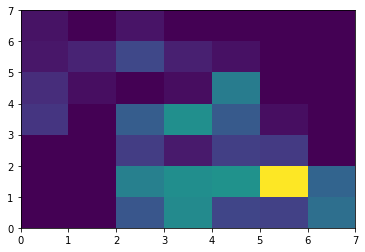

In [128]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(activ[14][0,1000,:,:].detach().cpu().numpy())

In [129]:
# Sanity check that we grabbed the right activations - check their sizes against expected
# output size of each block
exp_size = [model.visual.layer1[ii].conv3.weight.shape[0] for ii in range(blocks_each[0])] + \
            [model.visual.layer2[ii].conv3.weight.shape[0] for ii in range(blocks_each[1])] + \
            [model.visual.layer3[ii].conv3.weight.shape[0] for ii in range(blocks_each[2])] + \
            [model.visual.layer4[ii].conv3.weight.shape[0] for ii in range(blocks_each[3])]
actual_size = [activ[bb].shape[1] for bb in range(n_blocks)]
assert(np.all(np.array(actual_size)==np.array(exp_size)))

In [130]:
exp_size

[256,
 256,
 256,
 512,
 512,
 512,
 512,
 1024,
 1024,
 1024,
 1024,
 1024,
 1024,
 2048,
 2048,
 2048]

In [131]:
n_features_each_block = [256,256,256, 512,512,512,512, 1024,1024,1024,1024,1024,1024, 2048,2048,2048]

In [132]:
exp_size==n_features_each_block

True

In [ ]:
def get_clip_activations_batch(image_batch, layer_inds, device=None):

    """
    Get activations for images in NSD, passed through pretrained CLIP model.
    Specify which NSD images to look at, and which layers to return.
    """

    if device is None:
        device = torch.device('cpu:0')
       
    # The 16 residual blocks are segmented into 4 groups here, which have different numbers of features.
    blocks_each= [len(model.visual.layer1), len(model.visual.layer2), len(model.visual.layer3),len(model.visual.layer4)]
    which_group = np.repeat(np.arange(4), blocks_each)
    n_blocks = sum(blocks_each)
    block_names = ['block_%d'%bb for bb in range(n_blocks)]
    # compute how many feature maps will be in each 
    exp_size = [model.visual.layer1[ii].conv3.weight.shape[0] for ii in range(blocks_each[0])] + \
            [model.visual.layer2[ii].conv3.weight.shape[0] for ii in range(blocks_each[1])] + \
            [model.visual.layer3[ii].conv3.weight.shape[0] for ii in range(blocks_each[2])] + \
            [model.visual.layer4[ii].conv3.weight.shape[0] for ii in range(blocks_each[3])]
    
    # first loading pre-trained model from torch model zoo
    model = models.alexnet(pretrained=True).float().to(device)
    if padding_mode is not None:
        # change padding type for all convolutional layers, "reflect" is a
        # good way to minimize edge artifacts.
        for ff in model.features:
            if hasattr(ff, 'padding_mode'):
                ff.padding_mode=padding_mode
                print('changing padding mode to %s'%padding_mode)
                print(ff)
                
                
    model.eval()
    model_name='AlexNet'

    is_fc = [('FC' in alexnet_layer_names[ll] or 'fc' in alexnet_layer_names[ll]) for ll in layer_inds]
    
    if len(layer_inds)==0:
        raise ValueError('your layer names do not match any of those specified in alexnet_features.py')

    
    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii,ll):
        def hook(self, input, output):            
            print('hook for %s'%alexnet_layer_names[ll])           
            activ[ii] = output
            print(output.shape)
        return hook
   
    # get image and labels for this batch
    # image_tensors is [batch_size x 3 x 224 x 224]
    image_tensors =  torch_utils._to_torch(image_batch, device=device).float()
    activ = [[] for ll in layer_inds]
    hook = [[] for ll in layer_inds]
    
    model.eval()

    # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
    # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
    for ii, ll in enumerate(layer_inds):
        if not is_fc[ii]:
            h = model.features[ll].register_forward_hook(get_activ_fwd_hook(ii,ll))
        else:
            h = model.classifier[ll-n_feature_layers].register_forward_hook(get_activ_fwd_hook(ii,ll))
        hook[ii] = h

    # do the forward pass of model, which now includes the forward hooks
    # now the "activ" variable will get modified, because it gets altered during the hook function
    model(image_tensors)
    
    # Now remove all the hooks
    for ii, ll in enumerate(layer_inds):
        print(activ[ii].shape)
        hook[ii].remove

    return activ



In [ ]:
dtype=np.float32

# Define sets of alexnet layers
alexnet_conv_layer_names = ['Conv1','Conv1_ReLU','Conv1_MaxPool', \
                       'Conv2','Conv2_ReLU','Conv2_MaxPool', \
                       'Conv3','Conv3_ReLU', \
                       'Conv4','Conv4_ReLU', \
                       'Conv5','Conv5_ReLU','Conv5_MaxPool']

alexnet_fc_layer_names = ['Dropout6','FC6','FC6_ReLU','Dropout7','FC7','FC7_ReLU','FC8']

n_feature_layers = len(alexnet_conv_layer_names)
n_classif_layers = len(alexnet_fc_layer_names)
n_total_layers = n_feature_layers + n_classif_layers
alexnet_layer_names = copy.deepcopy(alexnet_conv_layer_names)
alexnet_layer_names.extend(alexnet_fc_layer_names)

n_features_each_layer = [64,64,64, 192,192,192, 384,384, 256,256, 256,256]

def get_features_each_prf(subject, use_node_storage=False, debug=False, \
                          which_prf_grid=1, padding_mode=None):
    """
    Extract the portion of CNN feature maps corresponding to pRF defined in "models"
    Return list of the features in each pRF, for each layer of interest.
    """
    
    device = initialize_fitting.init_cuda()
    if padding_mode=='':
        padding_mode = None
        
    if use_node_storage:
        alexnet_feat_path = default_paths.alexnet_feat_path_localnode
    else:
        alexnet_feat_path = default_paths.alexnet_feat_path

    # Load and prepare the image set to work with (all images for the current subject, 10,000 ims)
    stim_root = default_paths.stim_root
    image_data = nsd_utils.get_image_data(subject)  
    image_data = nsd_utils.image_uncolorize_fn(image_data)
   
    n_images = image_data.shape[0]
    
    # Params for the spatial aspect of the model (possible pRFs)
    prf_models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    

    # Fix these params
    n_prf_sd_out = 2
    batch_size = 50
    mult_patch_by_prf = True
    do_avg_pool = True
    
    layers_to_return = ['Conv1_ReLU', 'Conv2_ReLU','Conv3_ReLU','Conv4_ReLU','Conv5_ReLU']
    n_layers = len(layers_to_return)
    layer_inds = [ll for ll in range(len(alexnet_layer_names)) \
                      if alexnet_layer_names[ll] in layers_to_return]

    n_prfs = len(prf_models)
    features_each_prf = [np.zeros((n_images, n_features_each_layer[ll], n_prfs),dtype=dtype) for ll in layer_inds]

    n_batches = int(np.ceil(n_images/batch_size))

    with torch.no_grad():

        for bb in range(n_batches):

            if debug and bb>1:
                continue
            print('Processing images for batch %d of %d'%(bb, n_batches))

            batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))

            # using grayscale images for better comparison w my other models.
            # need to tile to 3 so alexnet weights will be right size
            image_batch = np.tile(image_data[batch_inds,:,:,:], [1,3,1,1])

            gc.collect()
            torch.cuda.empty_cache()
            
            activ_batch = get_alexnet_activations_batch(image_batch, layer_inds, \
                                                        device=device, padding_mode=padding_mode)

            for ll in range(n_layers):

                print('Getting prf-specific activations for layer %s'%alexnet_layer_names[layer_inds[ll]])

                maps_full_field = torch.moveaxis(activ_batch[ll], [0,1,2,3], [0,3,1,2])

                for mm in range(n_prfs):

                    if debug and mm>1:
                        continue

                    prf_params = prf_models[mm,:]
                    x,y,sigma = prf_params
                    print('Getting features for pRF [x,y,sigma]:')
                    print([x,y,sigma])
                    n_pix = maps_full_field.shape[1]

                    # Define the RF for this "model" version
                    prf = torch_utils._to_torch(prf_utils.gauss_2d(center=[x,y], sd=sigma, \
                               patch_size=n_pix, aperture=1.0, dtype=np.float32), device=device)
                    minval = torch.min(prf)
                    maxval = torch.max(prf-minval)
                    prf_scaled = (prf - minval)/maxval

                    if sigma==10:
                        # creating a "flat" pRF here which will average across entire feature map.
                        prf_scaled = torch.ones(prf_scaled.shape)
                        prf_scaled = prf_scaled/torch.sum(prf_scaled)
                        prf_scaled = prf_scaled.to(device)

                    if mult_patch_by_prf:
                        # This effectively restricts the spatial location, so no need to crop
                        maps = maps_full_field * prf_scaled.view([1,n_pix, n_pix,1])
                    else:
                        # This is a coarser way of choosing which spatial region to look at
                        # Crop the patch +/- n SD away from center
                        bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, \
                                                       min_pix=None, verbose=False, force_square=False)
                        print('bbox to crop is:')
                        print(bbox)
                        maps = maps_full_field[:,bbox[0]:bbox[1], bbox[2]:bbox[3],:]

                    if do_avg_pool:
                        features_batch = torch.mean(maps, dim=(1,2))
                    else:
                        features_batch = torch.max(maps, dim=(1,2))

                    print('model %d, min/max of features in batch: [%s, %s]'%(mm, \
                                                  torch.min(features_batch), torch.max(features_batch))) 

                    features_each_prf[ll][batch_inds,:,mm] = torch_utils.get_value(features_batch)

        # Now save the results, one file for each alexnet layer 
        for ii, ll in enumerate(layer_inds):
            if padding_mode is not None:
                fn2save = os.path.join(alexnet_feat_path, \
                   'S%d_%s_%s_features_each_prf_grid%d.h5py'%(subject, \
                                       alexnet_layer_names[ll], padding_mode, which_prf_grid))
            else:    
                fn2save = os.path.join(alexnet_feat_path, \
                   'S%d_%s_features_each_prf_grid%d.h5py'%(subject, \
                                           alexnet_layer_names[ll], which_prf_grid))
            print('Writing prf features to %s\n'%fn2save)

            t = time.time()
            with h5py.File(fn2save, 'w') as data_set:
                dset = data_set.create_dataset("features", np.shape(features_each_prf[ii]), dtype=np.float64)
                data_set['/features'][:,:,:] = features_each_prf[ii]
                data_set.close()  
            elapsed = time.time() - t

            print('Took %.5f sec to write file'%elapsed)


def get_alexnet_activations_batch(image_batch, layer_inds, device=None, padding_mode=None):

    """
    Get activations for images in NSD, passed through pretrained AlexNet.
    Specify which NSD images to look at, and which layers to return.
    """

    if device is None:
        device = torch.device('cpu:0')
       
    # first loading pre-trained model from torch model zoo
    model = models.alexnet(pretrained=True).float().to(device)
    if padding_mode is not None:
        # change padding type for all convolutional layers, "reflect" is a
        # good way to minimize edge artifacts.
        for ff in model.features:
            if hasattr(ff, 'padding_mode'):
                ff.padding_mode=padding_mode
                print('changing padding mode to %s'%padding_mode)
                print(ff)
                
                
    model.eval()
    model_name='AlexNet'

    is_fc = [('FC' in alexnet_layer_names[ll] or 'fc' in alexnet_layer_names[ll]) for ll in layer_inds]
    
    if len(layer_inds)==0:
        raise ValueError('your layer names do not match any of those specified in alexnet_features.py')

    
    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii,ll):
        def hook(self, input, output):            
            print('hook for %s'%alexnet_layer_names[ll])           
            activ[ii] = output
            print(output.shape)
        return hook
   
    # get image and labels for this batch
    # image_tensors is [batch_size x 3 x 224 x 224]
    image_tensors =  torch_utils._to_torch(image_batch, device=device).float()
    activ = [[] for ll in layer_inds]
    hook = [[] for ll in layer_inds]
    
    model.eval()

    # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
    # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
    for ii, ll in enumerate(layer_inds):
        if not is_fc[ii]:
            h = model.features[ll].register_forward_hook(get_activ_fwd_hook(ii,ll))
        else:
            h = model.classifier[ll-n_feature_layers].register_forward_hook(get_activ_fwd_hook(ii,ll))
        hook[ii] = h

    # do the forward pass of model, which now includes the forward hooks
    # now the "activ" variable will get modified, because it gets altered during the hook function
    model(image_tensors)
    
    # Now remove all the hooks
    for ii, ll in enumerate(layer_inds):
        print(activ[ii].shape)
        hook[ii].remove

    return activ